In [1]:
# General
import os
import sys
import shutil
import posixpath
import warnings
import importlib
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# SciPy
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.signal import periodogram, butter, filtfilt

# Gpflow & tensorflow
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import gpflow
f64 = gpflow.utilities.to_default_float
from gpflow.kernels import *

# Files
import csv
import pandas as pd
import seaborn as sns
import wfdb
from scipy.io import loadmat  

# Local scripts
#sys.path.insert(0, '/home/david/Documenten/Courses/Spectral Discontinuity Design/Thesis AI/Implementation/')
sys.path.insert(0, os.chdir(".."))
from SpectralMixture import SpectralMixture, initialize_from_emp_spec
import toolbox as t
from bnqdflow import models, base, effect_size_measures, util, analyses
sns.set(style='whitegrid')

### Load in data

In [2]:
# Analyses of patient 'sz01'
record = wfdb.rdrecord('datasets/post-ictal-heart-rate-oscillations-in-partial-epilepsy-1.0.0/sz01')
fs = record.fs
nyquist = fs / 2
with open('datasets/post-ictal-heart-rate-oscillations-in-partial-epilepsy-1.0.0/times.seize', 'r') as file:
    seizure_times = file.read()
    print(seizure_times)

sz01 00:14:36 00:16:12
sz02 01:02:43 01:03:43
sz02 02:55:51 02:56:16
sz03 01:24:34 01:26:22
sz03 02:34:27 02:36:17
sz04 00:20:10 00:21:55
sz05 00:24:07 00:25:30
sz06 00:51:25 00:52:19
sz06 02:04:45 02:06:10
sz07 01:08:02 01:09:31



In [3]:
# Read in recording 
fs          = record.fs
nyquist     = fs / 2
data        = record.p_signal.flatten()

start_time  = [0, 14, 36] # hours, minutes, seconds
end_time    = [0, 16, 12] # hours, minutes, seconds
duration    = 5 # seconds
n           = duration*fs 
b           = int(n/2)

start_index = start_time[0]*60*60*fs + start_time[1]*60*fs + start_time[2]*fs
end_index   = end_time[0]*60*60*fs + end_time[1]*60*fs + end_time[2]*fs

data        = data[start_index-b:start_index+b]


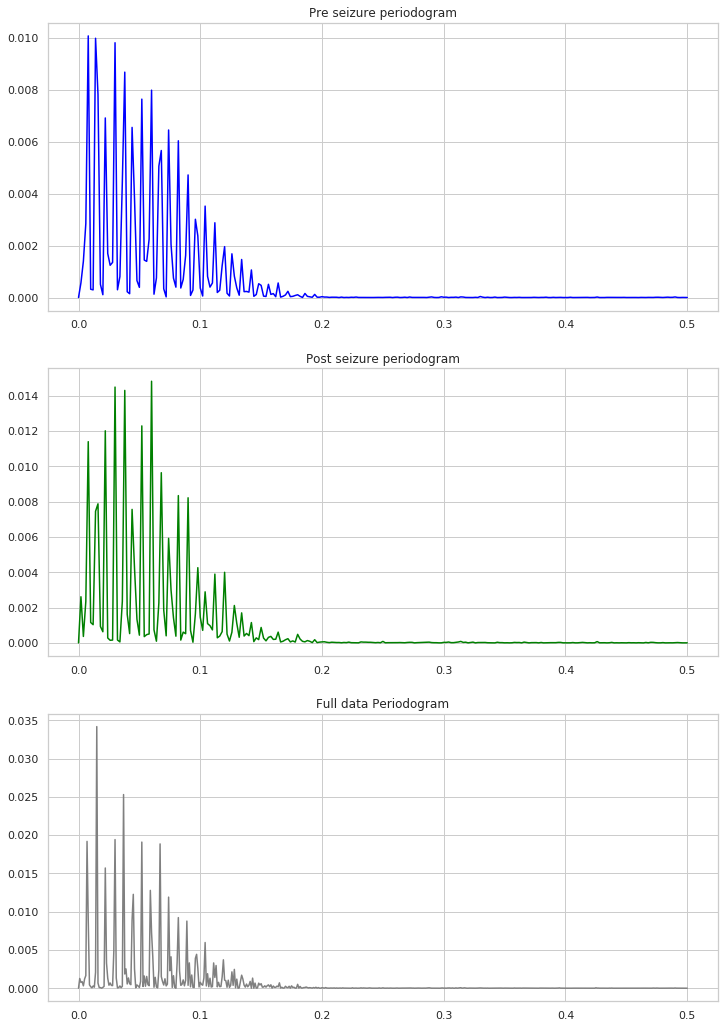

In [4]:
# plot unprocessed data
n_plots = 3
fig, ax = plt.subplots(n_plots,1, figsize=(12,6*n_plots))

# Plot periodogram
freqs, Pxx = periodogram(x=data[:b], fs=fs)
ax[0].plot(freqs/fs, Pxx, color='blue')
ax[0].set_title('Pre seizure periodogram')

freqs, Pxx = periodogram(x=data[b:], fs=fs)
ax[1].plot(freqs/fs, Pxx, color='green')
ax[1].set_title('Post seizure periodogram')

freqs, Pxx = periodogram(x=data, fs=fs)
ax[2].plot(freqs/fs, Pxx,color='grey')
ax[2].set_title('Full data Periodogram')
plt.show()

In [5]:
def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed


triangular_smoothing = True

if triangular_smoothing:
    degree = 2
    Y = np.array(smoothTriangle(data, degree))
    
    ### Downsample to 100Hz
    fs = fs/degree
    nyquist = fs/degree
    print('fs: ', round(fs,2), 'nyquist: ', round(nyquist,2))
    
    Y = Y[np.arange(int(n))%degree==0]
    n = int(n/degree)
    b = int(b/degree)
    

fs:  100.0 nyquist:  50.0


In [6]:
# Standardize data
zscorey = lambda x: (x - np.mean(Y)) / np.std(Y)
zscorex = lambda x: (x - np.mean(X)) / np.std(X)
X = np.arange(Y.shape[0])
b = zscorex(b)
X = zscorex(X)
Y = zscorey(Y)
print(f'Y Mean: {np.mean(Y)}, standard deviation: {np.std(Y)}')
print(f'X Mean: {np.mean(X)}, standard deviation: {np.std(X)}')

print(start_index, end_index)
print(n)
print(Y.shape)
print(b)

Y Mean: -7.105427357601002e-16, standard deviation: 0.9999999999999999
X Mean: 1.1368683772161603e-16, standard deviation: 1.0
175200 194400
500
(500,)
0.0034641085433617697


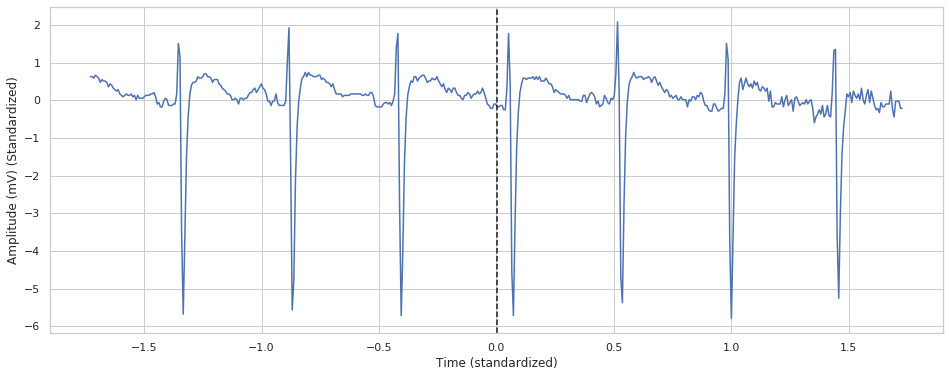

In [7]:
# Plot signal
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig, ax = plt.subplots(1,1,figsize=(16,6))
plt.plot(X,Y)
plt.axvline(b,color='k', linestyle='--')
#plt.xticks(np.arange(0,1200, 125),np.arange(0,5,0.5))
#plt.yticks([-0.5,-1,-1.5])
plt.ylabel('Amplitude (mV) (Standardized)')
plt.xlabel('Time (standardized)')
plt.show()

### Spectral Discontinuity Analysis

In [8]:
# Data used by the control model and intervention model
x1, x2      = X[X < b,], X[X>=b,]
y1, y2      = Y[X < b,], Y[X>=b,]

# Plotting parameters
padding           = 0.2
#ylim              = (-4.7,5.2)#(-2.5,2.3)
sns.set(style='white')

In [ ]:
# Model initialization & parameters
max_freq        = nyquist * 3
max_length      = 5.
Q               = 20 #t.find_optimal_Q(x, y, min_Q=1, max_Q=30, max_length=max_length, max_freq=max_freq, plot_BIC_scores=True)
sm              = SpectralMixture(Q, max_length=max_length, max_freq=max_freq)                
#set_sm_priors(sm)    

a               = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], sm, b, share_params=False)
a.train(verbose=True)

log_bayes_factor = a.log_bayes_factor(verbose=True)
t.plot_posterior_model_spectrum(a, Q, padding=padding, max_x = 500,lineplot=True, scalar = 1.)
plt.show()
print('Log bayes factor: ', log_bayes_factor.numpy())

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
╒═════════════════════════════════════════════════════════════╤═══════════╤════════════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════╕
│ name                                                        │ class     │ transform              │ prior   │ 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
t.plot_posterior_model_spectrum(a, Q, padding=padding, max_x = 500,lineplot=False, scalar = 1.)
plt.show()